#**Stock Price Prediction Using Time-Series Images**

The following project demonstrates how to handle stock price prediction using time series images. Follow these steps in order to implement it on your system.

1. If you haven't followed the previous steps, please do so before executing the following code, and if you have, execute the code block below and compress the files 'left' and 'right' before uploading them.


note: Please install the respective packages before proceeding with execution, in order to ensure a seamless experience.



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving left.zip to left.zip
Saving right.zip to right.zip


2. After the files have been uploaded, execute the code block below. Uncomment the portion below in order to ensure that the files inside the folders 'left' and 'right' have been extracted properly.

In [ ]:
import zipfile
import os

# List of uploaded zip files
zip_files = list(uploaded.keys())

for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()

# Verify extraction
# for zip_file in zip_files:
   # folder_name = zip_file.replace('.zip', '')
    # print(f'Contents of {folder_name}:')
    # for root, dirs, files in os.walk(folder_name):
        # for file in files:
            # print(os.path.join(root, file))


3. Execute the block below to define the transformer and load the dataset. Make sure to check the paths before execution.

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Define the custom dataset class
class PairedImageDataset(Dataset):
    def __init__(self, left_dir, right_dir, transform=None):
        self.left_dir = left_dir
        self.right_dir = right_dir
        self.left_images = sorted(os.listdir(left_dir))
        self.right_images = sorted(os.listdir(right_dir))
        self.transform = transform

    def __len__(self):
        return len(self.left_images)

    def __getitem__(self, idx):
        left_image_path = os.path.join(self.left_dir, self.left_images[idx])
        right_image_path = os.path.join(self.right_dir, self.right_images[idx])
        left_image = Image.open(left_image_path).convert("RGB")
        right_image = Image.open(right_image_path).convert("RGB")

        if self.transform:
            left_image = self.transform(left_image)
            right_image = self.transform(right_image)

        return left_image, right_image

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Instantiate the dataset and dataloader
left_dir = 'left'  # Change to the correct path
right_dir = 'right'  # Change to the correct path
dataset = PairedImageDataset(left_dir, right_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


4. Execute the following code to define the Encoder-Decoder architecture, and to initialize the model.

In [ ]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(x)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model
model = Autoencoder().cuda()


5. Execute the following in order to train the model and save it. Make sure the previous steps have been executed properly and the model being saved after training.

note: Adjust the value of epocs as per the neccessity, depending on data size and number of epochs, the process may take a while. Use custom loss function at your risk.

In [ ]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for i, (left, right) in enumerate(dataloader):
        left, right = left.cuda(), right.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(left)
        loss = criterion(outputs, right)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print loss
        if (i + 1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

# Assuming your training loop is here

# Save the model after training
torch.save(model.state_dict(), 'autoencoder_model.pth')
print('Model saved to autoencoder_model.pth')


Epoch [1/100], Step [50/50], Loss: 0.0708
Epoch [2/100], Step [50/50], Loss: 0.0314
Epoch [3/100], Step [50/50], Loss: 0.0206
Epoch [4/100], Step [50/50], Loss: 0.0165
Epoch [5/100], Step [50/50], Loss: 0.0165
Epoch [6/100], Step [50/50], Loss: 0.0151
Epoch [7/100], Step [50/50], Loss: 0.0137
Epoch [8/100], Step [50/50], Loss: 0.0157
Epoch [9/100], Step [50/50], Loss: 0.0142
Epoch [10/100], Step [50/50], Loss: 0.0144
Epoch [11/100], Step [50/50], Loss: 0.0133
Epoch [12/100], Step [50/50], Loss: 0.0141
Epoch [13/100], Step [50/50], Loss: 0.0124
Epoch [14/100], Step [50/50], Loss: 0.0126
Epoch [15/100], Step [50/50], Loss: 0.0122
Epoch [16/100], Step [50/50], Loss: 0.0121
Epoch [17/100], Step [50/50], Loss: 0.0129
Epoch [18/100], Step [50/50], Loss: 0.0133
Epoch [19/100], Step [50/50], Loss: 0.0125
Epoch [20/100], Step [50/50], Loss: 0.0119
Epoch [21/100], Step [50/50], Loss: 0.0106
Epoch [22/100], Step [50/50], Loss: 0.0120
Epoch [23/100], Step [50/50], Loss: 0.0110
Epoch [24/100], Step

6. Execute the folowing code in order to test the model on any stock of the training dataset. Feel free to skip this step in case you have your own test data.

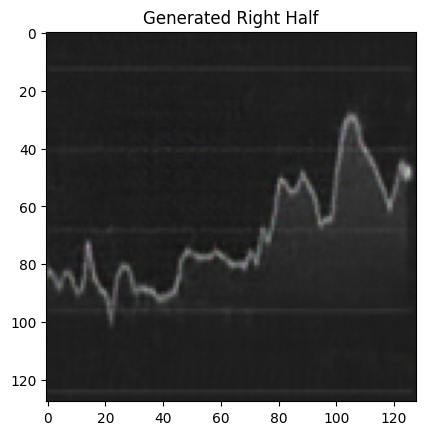

In [ ]:
# Evaluate on a sample image
model.eval()
sample_left, _ = dataset[0]
sample_left = sample_left.unsqueeze(0).cuda()  # Add batch dimension
with torch.no_grad():
    generated_right = model(sample_left)

# Display the results
generated_right = generated_right.squeeze(0).permute(1, 2, 0).cpu().numpy()
generated_right = (generated_right + 1) / 2  # De-normalize
plt.imshow(generated_right)
plt.title('Generated Right Half')
plt.show()



7. In order to test the model on an unknown/test image, upload the left and right parts of the test image and rename them as 'input.png' and 'actual_curve.png' before executing the code below. The generated image will be saved as 'output.png'.

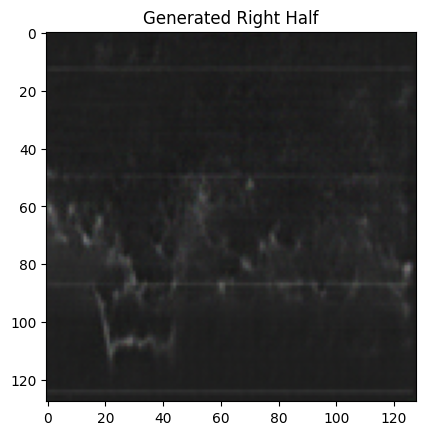

In [ ]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

# Define the function to load and preprocess the image
def load_and_preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Define the function to post-process, display, and save the output image
def postprocess_display_and_save_image(output_tensor, save_path):
    output_image = output_tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    output_image = (output_image + 1) / 2  # De-normalize
    plt.imshow(output_image)
    plt.title('Generated Right Half')
    plt.show()

    # Convert to PIL image and save
    output_image = (output_image * 255).astype(np.uint8)
    output_image = Image.fromarray(output_image)
    output_image.save(save_path)

# Load the trained model
model = Autoencoder().cuda()
model.load_state_dict(torch.load('autoencoder_model.pth'))  # Ensure you have saved your model
model.eval()

# Load and preprocess the input image
input_image_path = 'input.png'  # Change to your image path
input_image = load_and_preprocess_image(input_image_path).cuda()

# Perform inference
with torch.no_grad():
    output_image = model(input_image)

# Post-process, display, and save the output image
output_image_path = 'output.png'  # Specify the path to save the output image
postprocess_display_and_save_image(output_image, output_image_path)


8. The image above is of the raw output generated by the model. Most likely it may be fuzzy and uninterpretable. To extract a time series curve from the generated image, execute the code below, which will only keep the point with the most intensity in a column and remove the rest, and save it as 'extracted_time_series.png'.

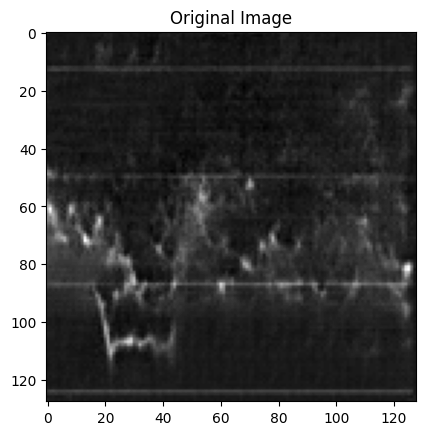

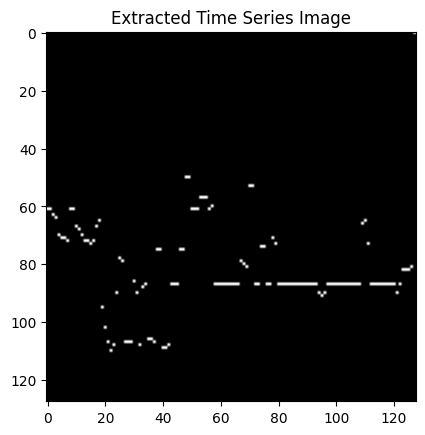

True

In [ ]:
from google.colab import files
import cv2

# Load the image
image_path = 'output.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded correctly
if image is None:
    raise ValueError("Image not loaded. Please check the file path and name.")

# Display the original image
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.show()

# Initialize an empty array for the output image
output_image = np.zeros_like(image)

# Loop through each column (x-coordinate)
for x in range(image.shape[1]):
    # Get the column
    column = image[:, x]
    # Find the index of the maximum intensity pixel in the column
    max_idx = np.argmax(column)
    # Check if the maximum intensity is greater than a threshold (e.g., 0)
    if column[max_idx] > 0:
        # Set the corresponding pixel in the output image to white (255)
        output_image[max_idx, x] = 255

# Display the output image
plt.imshow(output_image, cmap='gray')
plt.title('Extracted Time Series Image')
plt.show()

# Save the output image
output_image_path = 'extracted_time_series.png'
cv2.imwrite(output_image_path, output_image)

# Download the output image
# #files.download(output_image_path)


9. In order to find the trajectory from image 'extracted_time_series', execute the following code which will fit a best fit curve to the points and save it as 'fitted_curve.png'.

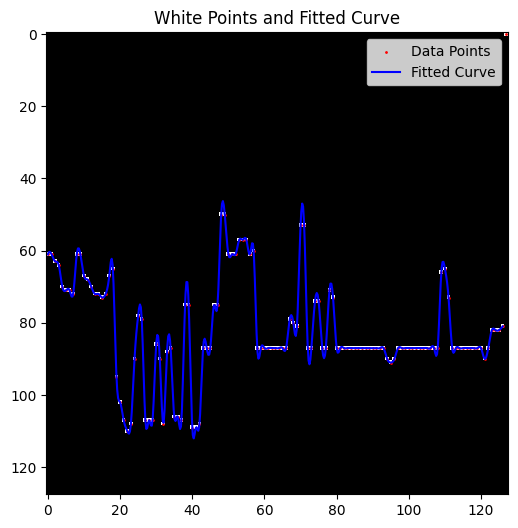

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Load the image
image_path = 'extracted_time_series.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Detect white points (assumed to be points with high intensity values)
_, thresh = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)

# Find coordinates of white points
coordinates = np.column_stack(np.where(thresh == 255))

# Sort points by x-coordinates for a smoother curve from left to right
sorted_coordinates = coordinates[np.argsort(coordinates[:, 1])]

# Discard the rightmost point
sorted_coordinates = sorted_coordinates[:-1]

# Interpolation using Univariate Spline
x = sorted_coordinates[:, 1]
y = sorted_coordinates[:, 0]
spline = UnivariateSpline(x, y, s=0)

# Generate a smooth curve
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = spline(x_smooth)

# Plot the image
plt.figure(figsize=(10, 6))
plt.imshow(image, cmap='gray')

# Plot the white points
plt.scatter(coordinates[:, 1], coordinates[:, 0], color='red', s=1, label='Data Points')

# Draw the fitted curve
plt.plot(x_smooth, y_smooth, color='blue', label='Fitted Curve')

plt.title('White Points and Fitted Curve')
plt.legend()

# Save the plot as a PNG image
plt.savefig('curve.png')

# Show the plot
plt.show()


10. Run this cell in order to compare the generated curve to the actual curve. Make sure the image of actual curve is saved as 'actual_curve.png'.

Mean Squared Error: 0.2029505763888889
Mean Absolute Error: 0.4406083333333333


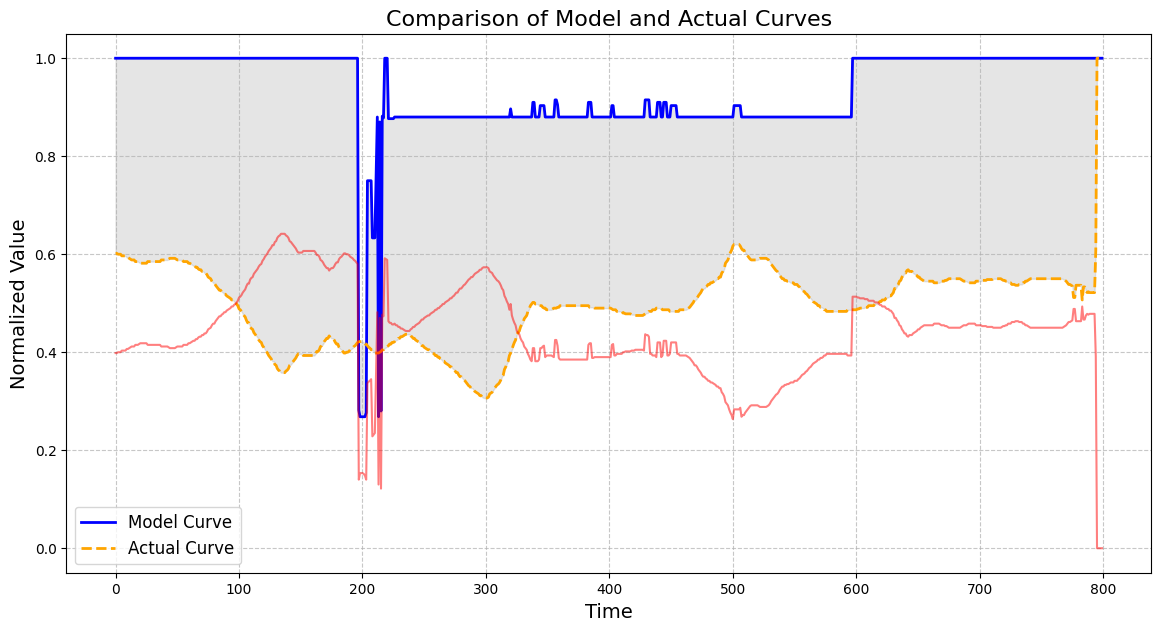

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Read the images
model_image_path = 'fitted_curve.png'
actual_image_path = 'actual_curve.png'

model_img = cv2.imread(model_image_path, cv2.IMREAD_GRAYSCALE)
actual_img = cv2.imread(actual_image_path, cv2.IMREAD_GRAYSCALE)

# Resize images to the same size
common_size = (800, 600)  # width, height
model_img = cv2.resize(model_img, common_size)
actual_img = cv2.resize(actual_img, common_size)

# Invert images if necessary
if np.mean(model_img) > 127:
    model_img = cv2.bitwise_not(model_img)
if np.mean(actual_img) > 127:
    actual_img = cv2.bitwise_not(actual_img)

# Extract curves
def extract_curve(img):
    height, width = img.shape
    curve = []
    for x in range(width):
        column = img[:, x]
        max_idx = np.argmax(column)
        curve.append(height - max_idx)
    return np.array(curve)

model_curve = extract_curve(model_img)
actual_curve = extract_curve(actual_img)

# Normalize the curves
model_curve = model_curve / np.max(model_curve)
actual_curve = actual_curve / np.max(actual_curve)

# Calculate error metrics
mse = mean_squared_error(actual_curve, model_curve)
mae = mean_absolute_error(actual_curve, model_curve)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Improved visualization
plt.figure(figsize=(14, 7))
plt.plot(model_curve, label='Model Curve', color='blue', linewidth=2)
plt.plot(actual_curve, label='Actual Curve', color='orange', linewidth=2, linestyle='--')
plt.fill_between(range(len(model_curve)), model_curve, actual_curve, color='gray', alpha=0.2)

plt.title('Comparison of Model and Actual Curves', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Normalized Value', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Highlighting the difference
plt.plot(np.abs(model_curve - actual_curve), label='Absolute Error', color='red', alpha=0.5)

plt.show()
